In [1]:
import tensorflow_federated as tff
import tensorflow as tf

# turn of tensorflow info messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print('hello')

hello


# Dataset

Using [speech commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). An audio dataset of spoken words designed to help train and evaluate keyword spotting systems. Its primary goal is to provide a way to build and test small models that detect when a single word is spoken, from a set of ten target words, with as few false positives as possible from background noise or unrelated speech. Note that in the train and validation set, the label "unknown" is much more prevalent than the labels of the target words or background noise. One difference from the release version is the handling of silent segments. While in the test set the silence segments are regular 1 second files, in the training they are provided as long segments under "background_noise" folder. Here we split these background noise into 1 second clips, and also keep one of the files for the validation set.



In [2]:
# !pip install wget
import wget


if not os.path.exists("speech_commands_v0.02.tar.gz"):
    url = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
    wget.download(url)
    print('downloaded')
    os.mkdir('speech_commands')
    !tar -xf 'speech_commands_v0.02.tar.gz' -C 'speech_commands/' > cat
else:
    print('Dataset already downloaded')

Dataset already downloaded


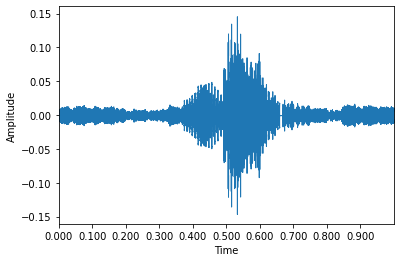

In [3]:
# !pip install librosa
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np


file = 'speech_commands/no/012c8314_nohash_0.wav'

signal, sr = librosa.load(file, sr=22050) # sr * T -> 22050 * 30
librosa.display.waveplot(signal, sr=sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# FFT

 - decompose complex periodic sound into sum of sine waves oscillating at different frequencies
 - Fast Fourier Transform: Amplitude-Time -> Magnitude-Frequency
 - No time information

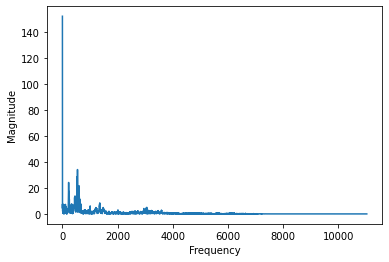

In [4]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

# STFT

 - computes several FFT at different intervals
 - preserves time information
 - fixed frame size (2048 samples)
 - gives a spectogram (time + frequency + magnitude)

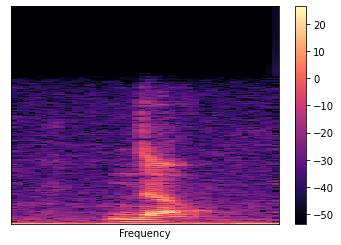

In [5]:
# stft -> spectogram
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)

log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.xlabel('Frequency')
plt.colorbar()
plt.show()

# MFCCs

Mel Frequency Cepstral Coefficients (MFCCs):
 - Capture timbral/textural aspects of sound
 - 13 to 40 coeffecients
 - approximates the human auditory system
 - calculated at each frame

MFCC applications:
 - speech recognition
 - music genre classification
 - music instrument classification

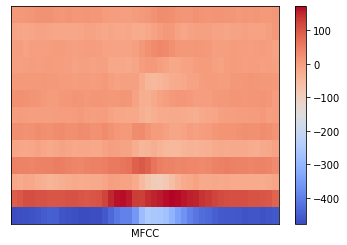

In [6]:
# MFCCs
MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.xlabel('MFCC')
plt.colorbar()
plt.show()


# Convert dataset to MFCCs

We need to convert all the audio waveforms into MFCCs to use in a neural network, so we use the library `librosa` to convert wav to MFCC given the standard sample rate of 22050. Then we save these MFCCs to a JSON file for later use so we don't have to convert every time.

In [2]:
import os
import librosa
import math
import json

DATASET_PATH = 'speech_commands'
JSON_PATH = 'data.json'
SAMPLE_RATE = 22050
DURATION = 1 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=40, n_fft=2048, hop_length=512):

    data = {
      'mapping': [],
      'mfcc': [],
      'labels': []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    label_number = 0
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            # for now only take x samples from each
            count = 0

            # save the semantic label
            dirpath_components = dirpath.split('/') # speech_commands/dog => ['speech_commands', 'dog']
            semantic_label = dirpath_components[-1]

            if semantic_label in ['.DS_Store', '.ipynb_checkpoints']:
                continue

            data['mapping'].append(semantic_label)

            print('Starting: {}'.format(semantic_label))
            
            for f in filenames:
                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                mfcc = librosa.feature.mfcc(signal,
                                            sr=sr,
                                            n_fft=n_fft,
                                            n_mfcc=n_mfcc,
                                            hop_length=hop_length)
                mfcc = mfcc.T

                # store mfcc for segment if it has the expected length
                if (len(mfcc)) == expected_num_mfcc_vectors_per_segment:
                    data['mfcc'].append(mfcc.tolist())
                    data['labels'].append(label_number)
                    count += 1

                if count % 100 == 0:
                  print('Done: {:4d}/{}'.format(count, len(os.listdir(dirpath))))
                
#                 if count == 500:
#                   break

            print('Done: {}'.format(semantic_label))
            label_number += 1

    with open('data.json', 'w') as fp:
        json.dump(data, fp, indent=4)


In [10]:
save_mfcc(DATASET_PATH, JSON_PATH)

Starting: right
Done:  100/3778
Done:  200/3778
Done:  300/3778
Done:  400/3778
Done:  500/3778
Done:  600/3778
Done:  700/3778
Done:  800/3778
Done:  900/3778
Done: 1000/3778
Done: 1100/3778
Done: 1200/3778
Done: 1300/3778
Done: 1400/3778
Done: 1500/3778
Done: 1600/3778
Done: 1700/3778
Done: 1800/3778
Done: 1800/3778
Done: 1900/3778
Done: 2000/3778
Done: 2100/3778
Done: 2200/3778
Done: 2300/3778
Done: 2400/3778
Done: 2500/3778
Done: 2600/3778
Done: 2700/3778
Done: 2800/3778
Done: 2900/3778
Done: 3000/3778
Done: 3100/3778
Done: 3100/3778
Done: 3200/3778
Done: 3300/3778
Done: 3400/3778
Done: right
Starting: eight
Done:  100/3787
Done:  200/3787
Done:  300/3787
Done:  400/3787
Done:  400/3787
Done:  500/3787
Done:  600/3787
Done:  700/3787
Done:  700/3787
Done:  800/3787
Done:  800/3787
Done:  900/3787
Done: 1000/3787
Done: 1100/3787
Done: 1200/3787
Done: 1200/3787
Done: 1300/3787
Done: 1400/3787
Done: 1500/3787
Done: 1600/3787
Done: 1700/3787
Done: 1800/3787
Done: 1900/3787
Done: 2000/3

# Loading the data

Now that we have the MFCCs stored in to JSON, we need to load it into memory. Once loaded, we use `train_test_split` to split the dataset into training and test sets.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import random

DATASET_PATH = 'data.json'
NUM_CLIENTS = 10

def load_data(dataset_path):
  with open(dataset_path, 'r') as fp:
    data = json.load(fp)
  
  # convert lists into numpy arrays
  inputs = np.array(data['mfcc'])
  targets = np.array(data['labels'])

  return inputs, targets

In [26]:
def get_dataset():
    inputs, targets = load_data(DATASET_PATH)

    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,
                                                                              targets,
                                                                              test_size=0.3)
    
    return inputs_train, inputs_test, targets_train, targets_test, inputs.shape

inputs_train, inputs_test, targets_train, targets_test, shape = get_dataset()

# Running a benchmark

As a benchmark, we create a cnn with keras and train the model for 50 epochs to compare to federated learning later

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1760)              0         
_________________________________________________________________
layer_normalization (LayerNo (None, 1760)              3520      
_________________________________________________________________
dense (Dense)                (None, 256)               450816    
_________________________________________________________________
dense_1 (Dense)              (None, 35)                8995      
Total params: 463,331
Trainable params: 463,331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2087/2087 [==============================] - 18s 8ms/step - loss: 2.2986 - accuracy: 0.3766 - val_loss: 1.8633 - val_accuracy: 0.4838
Epoch 2/200
2087/2087 [==============================] - 17s 8ms/step - loss: 1.6417 - accuracy: 0.549

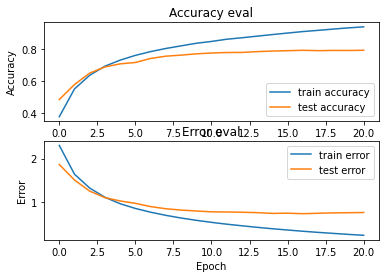

In [5]:
model = keras.Sequential([
  # input layer
  keras.layers.Flatten(input_shape=(shape[1], shape[2])),

  # 1st hidden layer
#   keras.layers.Dense(512, activation='relu'),

  # dropout 1
#   keras.layers.Dropout(0.25),
  keras.layers.LayerNormalization(),

  # 2nd hidden layer
  keras.layers.Dense(256, activation='relu'),

  # dropout 2
#   keras.layers.Dropout(0.25),

  # 3rd hidden layer
#   keras.layers.Dense(64, activation='relu'),

  # output layer
  keras.layers.Dense(35, activation='softmax')
])

# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

import matplotlib.pyplot as plt

def plot_history(history):
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  plt.show()

NUM_EPOCHS = 200
BATCH_SIZE = 32

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
# train network
history = model.fit(inputs_train, targets_train, 
          validation_data=(inputs_test, targets_test),
          epochs=NUM_EPOCHS,
          callbacks=[es],
          batch_size=BATCH_SIZE)

plot_history(history)

# Separating into clients

Since the `speech_commands` dataset isn't federated, we separate the data at random into different client buckets.

In [27]:
client_data_train = {i:[[], []] for i in range(1, 51)}
client_data_test = {i:[[], []] for i in range(51, 101)}
print(client_data_train)
print(client_data_test)
for i in range(len(inputs_train)):
  r = random.randint(1, 50)
  client_data_train[r][0].append(inputs_train[i])
  client_data_train[r][1].append(targets_train[i])
for i in range(len(inputs_test)):
  r = random.randint(51, 100)
  client_data_test[r][0].append(inputs_test[i])
  client_data_test[r][1].append(targets_test[i])

{1: [[], []], 2: [[], []], 3: [[], []], 4: [[], []], 5: [[], []], 6: [[], []], 7: [[], []], 8: [[], []], 9: [[], []], 10: [[], []], 11: [[], []], 12: [[], []], 13: [[], []], 14: [[], []], 15: [[], []], 16: [[], []], 17: [[], []], 18: [[], []], 19: [[], []], 20: [[], []], 21: [[], []], 22: [[], []], 23: [[], []], 24: [[], []], 25: [[], []], 26: [[], []], 27: [[], []], 28: [[], []], 29: [[], []], 30: [[], []], 31: [[], []], 32: [[], []], 33: [[], []], 34: [[], []], 35: [[], []], 36: [[], []], 37: [[], []], 38: [[], []], 39: [[], []], 40: [[], []], 41: [[], []], 42: [[], []], 43: [[], []], 44: [[], []], 45: [[], []], 46: [[], []], 47: [[], []], 48: [[], []], 49: [[], []], 50: [[], []]}
{51: [[], []], 52: [[], []], 53: [[], []], 54: [[], []], 55: [[], []], 56: [[], []], 57: [[], []], 58: [[], []], 59: [[], []], 60: [[], []], 61: [[], []], 62: [[], []], 63: [[], []], 64: [[], []], 65: [[], []], 66: [[], []], 67: [[], []], 68: [[], []], 69: [[], []], 70: [[], []], 71: [[], []], 72: [[], []],

In [29]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def create_train_tf_dataset_for_client_fn(client_id):
  # a function which takes a client_id and returns a
  # tf.data.Dataset for that client
  client_data = client_data_train[client_id]
  client_inputs, client_targets = client_data[0], client_data[1]
  dataset = tf.data.Dataset.from_tensor_slices((client_inputs, client_targets))
  dataset = dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)
  return dataset

def create_test_tf_dataset_for_client_fn(client_id):
  # a function which takes a client_id and returns a
  # tf.data.Dataset for that client
  client_data = client_data_test[client_id]
  client_inputs, client_targets = client_data[0], client_data[1]
  dataset = tf.data.Dataset.from_tensor_slices((client_inputs, client_targets))
  dataset = dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)
  return dataset

train_data = tff.simulation.datasets.ClientData.from_clients_and_fn(
        client_ids=range(1, 51),
        create_tf_dataset_for_client_fn=create_train_tf_dataset_for_client_fn
    )
test_data = tff.simulation.datasets.ClientData.from_clients_and_fn(
        client_ids=range(51, 101),
        create_tf_dataset_for_client_fn=create_test_tf_dataset_for_client_fn
    )

In [30]:
example_dataset = train_data.create_tf_dataset_for_client(
    train_data.client_ids[0])
input_spec = example_dataset.element_spec

In [31]:
def create_keras_model():
  return keras.models.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(shape[1], shape[2])),

    # 1st hidden layer
#     keras.layers.Dense(512, activation='relu'),

    # # # dropout 1
#     keras.layers.Dropout(0.25),
    keras.layers.LayerNormalization(),

    # 2nd hidden layer
    keras.layers.Dense(256, activation='relu'),

    # # dropout 2
#     keras.layers.Dropout(0.5),

    # 3rd hidden layer
#     keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(35, activation='softmax')
  ])

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=input_spec,
      loss=keras.losses.SparseCategoricalCrossentropy(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

# An iterative process

The current model of federated learning is iterative, so we build an iterative model not dissimilar to the benchmark model.

In [32]:
import nest_asyncio
nest_asyncio.apply()

In [35]:
total_clients = len(train_data.client_ids)
# test_data_unfed = tf.data.Dataset.from_tensor_slices((inputs_test, targets_test))
# test_data_unfed = [(x, y) for (x, y) in zip(inputs_test, targets_test)]

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients  # constants
    

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  if noise_multiplier == 0:
    learning_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: keras.optimizers.Adam(learning_rate=0.0002),
        server_optimizer_fn=lambda: keras.optimizers.SGD(learning_rate=1.0))
  else:
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)
    learning_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: keras.optimizers.Adam(learning_rate=0.0002),
        server_optimizer_fn=lambda: keras.optimizers.SGD(learning_rate=1.0),
        model_update_aggregation_factory=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(model_fn)

  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round >= 10 and round % 10 == 0:
      a = [test_data.create_tf_dataset_for_client(client) for client in test_data.client_ids]
      metrics = eval_process(state.model, a)
      # if round < 25 or round % 25 == 0:
      print('Round {:3d}: val={}'.format(round, metrics['sparse_categorical_accuracy']))
      data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)
      a.clear()
      a = None
      
    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]
    
    # Use selected clients for update.
    state, metrics = learning_process.next(state, sampled_train_data)
    print('round {:3d}, train={}'.format(round, metrics['train']))
        
    sampled_train_data.clear()
    sampled_train_data = None
    
    sampled_clients.clear()
    sampled_clients = None
    
    x = None
    
  a = [test_data.create_tf_dataset_for_client(client) for client in test_data.client_ids]
  metrics = eval_process(state.model, a)
  print(f'Round {rounds:3d}: {metrics}')
  data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)


# iterative_process = tff.learning.build_federated_averaging_process(
#     model_fn,
#     client_optimizer_fn=lambda: keras.optimizers.Adam(learning_rate=0.0001),
#     server_optimizer_fn=lambda: keras.optimizers.SGD(learning_rate=1.0)
#     )


In [36]:
import pandas as pd


data_frame = pd.DataFrame()
rounds = 50
clients_per_round = 25

for noise_multiplier in [0, 0.1, 0.2, 0.3]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0
round   0, train=OrderedDict([('sparse_categorical_accuracy', 0.22060692), ('loss', 2.9969122)])
round   1, train=OrderedDict([('sparse_categorical_accuracy', 0.3611186), ('loss', 2.4401758)])
round   2, train=OrderedDict([('sparse_categorical_accuracy', 0.4344623), ('loss', 2.1385868)])
round   3, train=OrderedDict([('sparse_categorical_accuracy', 0.480179), ('loss', 1.953306)])
round   4, train=OrderedDict([('sparse_categorical_accuracy', 0.51513284), ('loss', 1.8251762)])
round   5, train=OrderedDict([('sparse_categorical_accuracy', 0.542156), ('loss', 1.7189177)])
round   6, train=OrderedDict([('sparse_categorical_accuracy', 0.56544113), ('loss', 1.6395721)])
round   7, train=OrderedDict([('sparse_categorical_accuracy', 0.5892685), ('loss', 1.5533421)])
round   8, train=OrderedDict([('sparse_categorical_accuracy', 0.608566), ('loss', 1.4836973)])
round   9, train=OrderedDict([('sparse_categorical_accuracy', 0.6258843), ('loss', 1.4175086)]

IOStream.flush timed out
IOStream.flush timed out


round  25, train=OrderedDict([('sparse_categorical_accuracy', 0.80263966), ('loss', 0.7903025)])
round  26, train=OrderedDict([('sparse_categorical_accuracy', 0.8162145), ('loss', 0.74734366)])
round  27, train=OrderedDict([('sparse_categorical_accuracy', 0.81916106), ('loss', 0.73097056)])
round  28, train=OrderedDict([('sparse_categorical_accuracy', 0.8228376), ('loss', 0.71943396)])
round  29, train=OrderedDict([('sparse_categorical_accuracy', 0.8255887), ('loss', 0.70863545)])
Round  30: val=0.6997798681259155
round  30, train=OrderedDict([('sparse_categorical_accuracy', 0.8325746), ('loss', 0.68112063)])
round  31, train=OrderedDict([('sparse_categorical_accuracy', 0.83937657), ('loss', 0.6623797)])
round  32, train=OrderedDict([('sparse_categorical_accuracy', 0.8427935), ('loss', 0.6516575)])
round  33, train=OrderedDict([('sparse_categorical_accuracy', 0.8431209), ('loss', 0.64488643)])
round  34, train=OrderedDict([('sparse_categorical_accuracy', 0.8525268), ('loss', 0.61535907

TypeError: no numeric data to plot

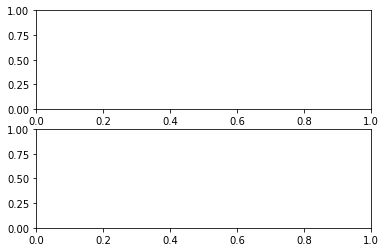

In [37]:
import matplotlib.pyplot as plt

def make_plot(data_frame):
  fig, axes = plt.subplots(nrows=2, ncols=1)

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'},
  )

  dff.plot.line(ax=axes[0])
#   sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
#   dff.plot.line(ax=axes[1], x='Round')
#   sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

make_plot(data_frame)

In [38]:
data_frame.index.name = None
data_frame.to_csv('results.csv')